# Modelo de aprendizaje

Como proyecto de ciencia de datos, considero que para llamarlo con tal debo aplicar un modelo de ML para generar un codigo de produccion. Asi que manos a la obra.

## 1. Impotar paquetes

In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns

## 2. Carga de los datos

In [59]:
ruta = 'C:/Users/matia/OneDrive/Escritorio/Water_Quality'
trabajo = 'trabajo_resultado_calidad.pickle'
df = pd.read_pickle(ruta + '/02_Datos/03_Trabajo/' + trabajo)

## 3. Valores nulos

El trato de los datos nulos en el notebook anterior no fue aplicado y guardado, asi que hay que aplicarlo ahora antes de implementar el modelo.

In [60]:
x = df.drop('Potability', axis = 1)
y = df['Potability']

x = x.fillna(x.median())

In [61]:
x.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

## 4. Modelizacion

### 4.1 Separacion del dataset de validacion

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

### 4.2 Creacion de la Pipeline

Voy a aplicar una Pipeline con 3 algoritmo de clasificacion para ver cual entrega el mejor resultado para este dataset.

In [34]:
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('algoritmo', RandomForestClassifier())
])

In [40]:
grid = [
    {'algoritmo': [GradientBoostingClassifier()],
    'algoritmo__n_estimators': [50, 100, 150],
    'algoritmo__learning_rate': [0.01, 0.1, 0.2],
    'algoritmo__max_depth': [3, 5, 7]},
    {'algoritmo': [RandomForestClassifier()],
    'algoritmo__n_estimators': [50, 100, 150],
    'algoritmo__max_depth': [None, 10, 20],
    'algoritmo__min_samples_split': [2, 5, 10]},
    {'algoritmo': [BaggingClassifier()],
    'algoritmo__n_estimators': [10, 50, 100],
    'algoritmo__max_samples': [0.5, 0.75, 1.0]},
    ]

Ahora se entrenan los modelos y se recupera el mejor resultado.

In [41]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'roc_auc',
                           verbose = 0,
                           n_jobs = -1)

modelo = grid_search.fit(x_train,y_train)

pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo,param_algoritmo__learning_rate,param_algoritmo__max_depth,param_algoritmo__n_estimators,param_algoritmo__min_samples_split,param_algoritmo__max_samples,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
62,3.196437,0.258363,0.034868,0.004844,BaggingClassifier(),NaN,NaN,100,NaN,1.0,"{'algoritmo': BaggingClassifier(), 'algoritmo_...",0.658351,0.684590,0.654750,0.665897,0.013299,1
35,2.628368,0.197775,0.076003,0.007284,RandomForestClassifier(),NaN,None,150,10,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.653112,0.685710,0.637189,0.658670,0.020195,2
50,2.658576,0.210929,0.075027,0.007430,RandomForestClassifier(),NaN,20,150,5,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.660536,0.667210,0.644711,0.657485,0.009435,3
37,1.482475,0.093888,0.053464,0.006328,RandomForestClassifier(),NaN,10,100,2,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.646157,0.675985,0.642689,0.654944,0.014946,4
59,3.525886,0.174649,0.061985,0.013010,BaggingClassifier(),NaN,NaN,100,NaN,0.75,"{'algoritmo': BaggingClassifier(), 'algoritmo_...",0.657409,0.672960,0.633175,0.654514,0.016371,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1.644888,0.100452,0.015534,0.004031,GradientBoostingClassifier(),0.01,3,150,NaN,NaN,"{'algoritmo': GradientBoostingClassifier(), 'a...",0.609508,0.621950,0.562028,0.597829,0.025820,59
9,0.976699,0.032441,0.011008,0.000406,GradientBoostingClassifier(),0.1,3,50,NaN,NaN,"{'algoritmo': GradientBoostingClassifier(), 'a...",0.608627,0.598831,0.580397,0.595952,0.011703,60
1,1.065082,0.067476,0.008845,0.000936,GradientBoostingClassifier(),0.01,3,100,NaN,NaN,"{'algoritmo': GradientBoostingClassifier(), 'a...",0.616466,0.618983,0.552144,0.595864,0.030932,61
54,0.290481,0.007046,0.016245,0.001335,BaggingClassifier(),NaN,NaN,10,NaN,0.5,"{'algoritmo': BaggingClassifier(), 'algoritmo_...",0.586067,0.613505,0.582944,0.594172,0.013730,62


### 4.3 Prediccion

In [52]:
pred = modelo.best_estimator_.predict_proba(x_test)[:, 1]

In [48]:
roc_auc_score(y_test, pred) * 100

68.29661126143539

### 4.4 Recuperacion del mejor modelo

In [53]:
modelo.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('algoritmo', BaggingClassifier(n_estimators=100))])

## 5. Aplicacion del mejor modelo

In [63]:
scale = StandardScaler()
x_train=scale.fit_transform(x_train)
x_test=scale.transform(x_test)
modelo = BaggingClassifier(n_estimators = 100)
modelo.fit(x_train,y_train)
pred = modelo.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       593
           1       0.66      0.40      0.50       390

    accuracy                           0.68       983
   macro avg       0.67      0.63      0.63       983
weighted avg       0.68      0.68      0.66       983



<Axes: >

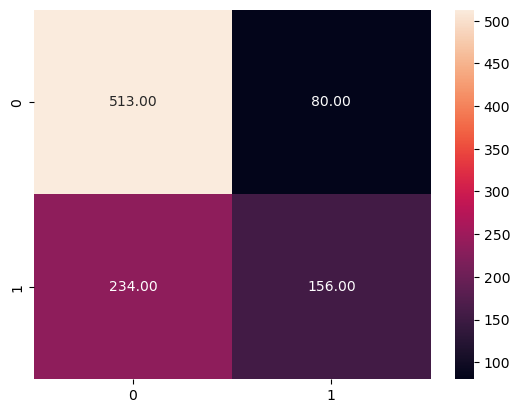

In [66]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.2f')

**Analisis de los resultados:** que entregan las metricas nos indican que el modelo tiene alta capacidad de detectar los registros de agua no potable, dado el valor que arroja el F1 Score. Por otro lado el modelo presenta dificultad para detectar bien las muestras de agua potable, lo cual no es un resultado optimo, aunque eso es a nivel de detectar verdades positovos y los falsos postivos estan afectando los resultados.